In [3]:
import torch 
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from ResNet import ResNet
from backup import ImageTransform
import math

In [4]:
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
class Display_samples(object):

    def __init__(self, dataset_path, model_path, dev='cpu'):

        self.dataset_path = dataset_path 
        self.image_names = os.listdir(self.dataset_path)
        self.image_names.remove('.DS_Store')
        self.image_paths = [os.path.join(self.dataset_path, x) for x in self.image_names]
        self.model_path = model_path 
        self.dev = dev

        self.load_model()

    def load_model(self):
        self.model = ResNet().to(self.dev)
        self.model.load_state_dict(torch.load(self.model_path, map_location=self.dev))
        self.model.eval()

    def post_process_image(self, data):
        img = data.clone().clamp(0,255).detach().numpy()
        img = img.transpose(1,2,0).astype('uint8')
        img = Image.fromarray(img)
        return img


    def display(self, size_threshold=600, show_original=True, save=False):
        to_tensor = transforms.ToTensor()
        to_image = transforms.ToPILImage()

        ncols = 4
        nrows = 2 if show_original else 1
        nfigs = math.ceil(len(self.image_paths)/ncols)
        img_counter = 0

        for i in range(nfigs):
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(23,12))

            if show_original : 
                ax1, ax2 = ax 
            else : 
                ax2 = ax
                ax1 = torch.ones((ax.shape))

            for ax_1, ax_2 in zip(ax1, ax2): 

                try : 

                    img = Image.open(self.image_paths[img_counter]).convert('RGB')
                    img_counter += 1
                    h, w = img.size 
                    
                    while h > size_threshold or w > size_threshold : 
                        h = int(h/1.2)
                        w = int(w/1.2)
                        img = img.resize((h,w), Image.ANTIALIAS)

                    img_tensor = to_tensor(img).unsqueeze(0)

                    out_tensor = self.model.forward(img_tensor)
                    out_img = self.post_process_image(out_tensor[0])

                    if show_original : 
                        ax_1.imshow(img)
                        ax_1.axis(False)

                    ax_2.imshow(out_img)
                    ax_2.axis(False)
                    
                except IndexError : 
                    pass

            self.fig = fig
            if save : 
                self.savefig()

    def savefig(self):
        rootdir = os.path.dirname(os.path.abspath(self.model_path))
        modelname = os.path.basename(self.model_path)
        savename = modelname[:-3] + '.png'
        save_path = os.path.join(rootdir, savename)
        self.fig.savefig(save_path, bbox_inches='tight', transparent=True, pad_inches=0)

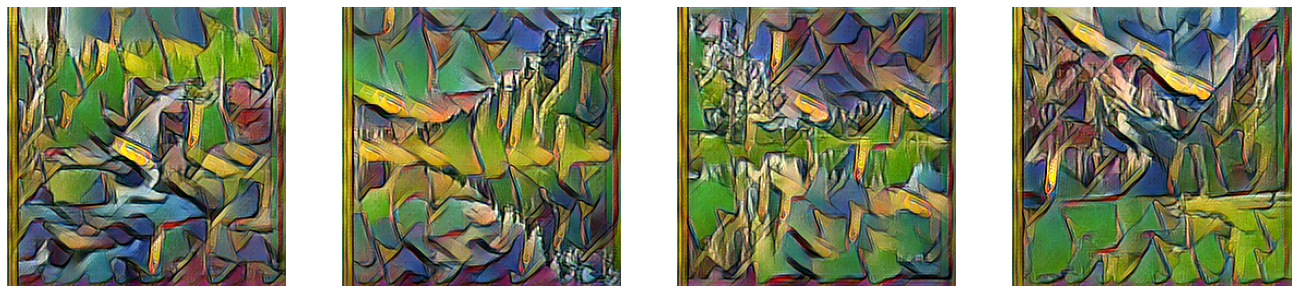

In [16]:
data = '/Users/gursi/Desktop/good' 
model = '/Users/gursi/Desktop/Neural_style_transfer/models_outputs/muse/4e9muse.pt'
display = Display_samples(dataset_path = data, model_path=model)
fig = display.display(size_threshold=600, show_original=False, save=False)